# E. coli Glycolytic Network Construction
## Growth Medium: Glucose
Growth data obtained from the following sources: 
- Gerosa, Luca et al. “Pseudo-transition Analysis Identifies the Key Regulators of Dynamic Metabolic Adaptations from Steady-State Data.” Cell systems vol. 1,4 (2015): 270-82. doi:10.1016/j.cels.2015.09.008


- Volkmer, Benjamin, and Matthias Heinemann. “Condition-dependent cell volume and concentration of Escherichia coli to facilitate data conversion for systems biology modeling.” PloS one vol. 6,7 (2011): e23126. doi:10.1371/journal.pone.0023126


### Import packages

In [65]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass


import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

import mass
from mass import MassConfiguration, MassModel, MassMetabolite, MassReaction, Simulation
from mass.io.json import save_json_model as save_mass_json_model
from mass.visualization import plot_comparison, plot_time_profile


print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

COBRApy version: 0.23.0
MASSpy version: 0.1.7


### Set solver

In [66]:
MASSCONFIGURATION = MassConfiguration()
MASSCONFIGURATION.solver = "gurobi"

## Load COBRA model

In [67]:
cobra_model = load_cobra_json_model(f"./models/cobra/iML1515.json")

## Obtain Flux State
### Load growth data

In [68]:
medium = "Glucose"
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data",
    index_col=0
)
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data_reduced",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
Rxn,
GLCptspp,9.613287
PGI,5.698950
PFK,7.057500
FBP,0.000000
FBA,7.057500
...,...
L_LACD2,0.000000
CYTBO3_4pp,38.191466
CYTBDpp,0.000000


### Set bounds
#### Growth rate and media

In [69]:
biomass_rxn = cobra_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M
growth_rate = flux_data.loc[biomass_rxn.id][0] #This index is hard-coded based on which column has the flux value
biomass_rxn.bounds = (0, growth_rate)
biomass_rxn.bounds

(0, 0.455338783207954)

In [70]:
growth_rate

0.455338783207954

In [71]:
EX_glc__D_e = cobra_model.reactions.EX_glc__D_e
medium_uptake = flux_data.loc[EX_glc__D_e.id][0] #This index is hard-coded based on which column has the flux value
EX_glc__D_e.bounds = (medium_uptake, 0)
EX_glc__D_e.bounds

(-9.655, 0)

### Formulate QP minimization for fluxes

In [72]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
reverse_flux_percent = 0.1

irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]

for rid, flux in flux_data.itertuples():
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
            
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()
flux_solution

PFK 7.76325
FBP 0.7057500000000001
PYK 2.73493
PPS 0.24863000000000002


,fluxes,reduced_costs
CYTDK2,0.000000,0.0
XPPT,0.000000,0.0
HXPRT,0.000000,0.0
NDPK5,0.000000,0.0
SHK3Dr,0.211771,0.0
...,...,...
MPTS,0.000000,0.0
MOCOS,0.000000,0.0
BMOGDS2,0.000000,0.0
FESD2s,0.000000,0.0


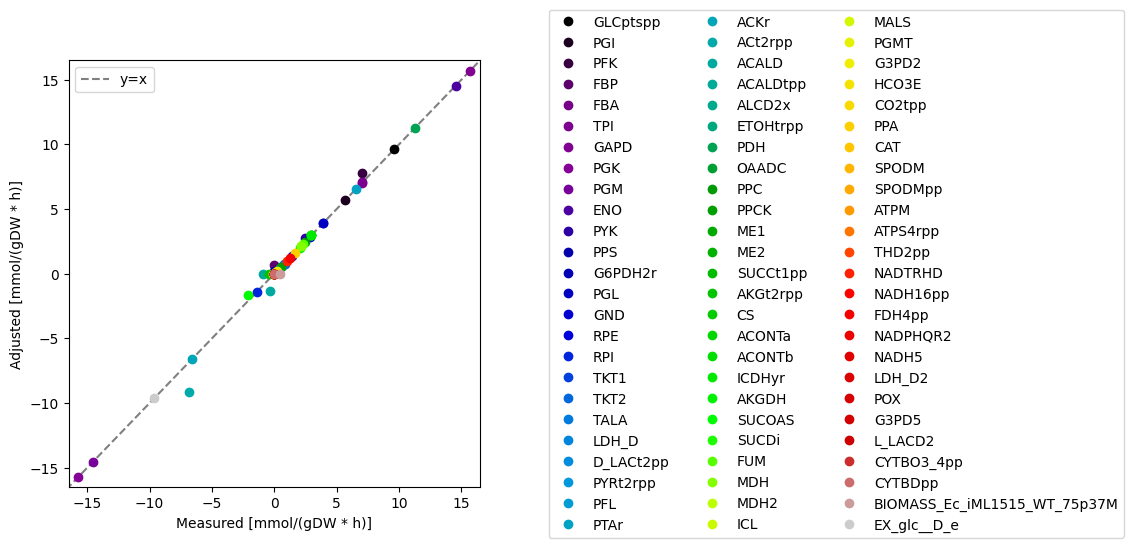

In [73]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Flux (mmol * gDW-1 * h-1)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_data.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

#### Export data for analysis

In [74]:
flux_data_for_comparison = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
flux_data_for_comparison.index.name = "ID"
flux_data_for_comparison.columns = ["Initial", "Adjusted"]
flux_data_for_comparison.to_csv("./data/analysis_data/fluxes_extended.csv")

## Create MASS Model

In [75]:
# Create MassModel
mass_model = MassModel("CentralMetabolism", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "GLCptspp",
"PGI",
"PFK",
"FBP",
"FBA",
"TPI",
"GAPD",
"PGK",
"PGM",
"ENO",
"PYK",
"PPS",
"G6PDH2r",
"PGL",
"GND",
"RPE",
"RPI",
"TKT1",
"TKT2",
"TALA",
"LDH_D",
"D_LACt2pp",
"PYRt2rpp",
"PFL",
"PTAr",
"ACKr",
"ACt2rpp",
"ACALD",
"ACALDtpp",
"ALCD2x",
"ETOHtrpp",
"PDH",
"OAADC",
"PPC",
"PPCK",
"ME1",
"ME2",
"SUCCt1pp",
"AKGt2rpp",
"CS",
"ACONTa",
"ACONTb",
"ICDHyr",
"AKGDH",
"SUCOAS",
"SUCDi",
"FUM",
"MDH",
"MDH2",
"ICL",
"MALS",
"PGMT",
"G3PD2",
"HCO3E",
"CO2tpp",
"PPA",
"CAT",
"SPODM",
"SPODMpp",
"ATPM",
"ATPS4rpp",
"THD2pp",
"NADTRHD",
"NADH16pp",
"FDH4pp",
"NADPHQR2",
"NADH5",
"LDH_D2",
"POX",
"G3PD5",
"L_LACD2",
"CYTBO3_4pp",
"CYTBDpp",
]

cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,CentralMetabolism
Memory address,0x01f8e8220e88
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,0/70
Number of reactions,73
Number of genes,68
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Convert flux units to M/s

In [76]:
T = 313.15
gas_constant = 0.008314
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter

# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 42000 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL

# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)

for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001 / 3600 

## Set equilibrium constants

In [77]:
Keq_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="Keq_data",
    index_col=0
)
for reaction in mass_model.reactions.get_by_any(reaction_list):
    reaction.Keq = Keq_data.loc[reaction.Keq_str][0]

In [78]:
conc_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
10fthf_c,1.051286e-04
13dpg_c,5.507545e-05
23dhb_c,1.380000e-04
2ddg6p_c,1.247644e-05
2dmmql8,1.051286e-04
...,...
utp_c,8.290000e-03
val__L_c,4.020000e-03
xu5p__D_c,6.447318e-04


### Add PFK1 activator GDP

In [79]:
#gdp_c = MassMetabolite(cobra_model.metabolites.gdp_c)
# Set the activator as a constant
#gdp_c.fixed = True

#mass_model.add_metabolites(gdp_c)

### Set initial concentrations from growth data

In [80]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})

# Fix hydrogen and water as constants and set concentration to 1.
for metabolite in mass_model.metabolites.get_by_any(["h2o_c", "h_c"]):
    metabolite.fixed = True
    metabolite.initial_condition = 1

missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
# Provide initial guesses for missing metabolites (pi_c, g3p_c, and lac__D_c)
print(missing_ics)
for metabolite in missing_ics:
    metabolite.initial_condition = 0.001

[<MassMetabolite glc__D_p at 0x1f8e8220ec8>, <MassMetabolite 6pgl_c at 0x1f8e8271b88>, <MassMetabolite lac__D_c at 0x1f8e91eb088>, <MassMetabolite h_p at 0x1f8e91eb608>, <MassMetabolite lac__D_p at 0x1f8e91eb588>, <MassMetabolite pyr_p at 0x1f8e91e6d88>, <MassMetabolite ac_p at 0x1f8e91f3a08>, <MassMetabolite acald_c at 0x1f8e91f3a88>, <MassMetabolite acald_p at 0x1f8e91f3fc8>, <MassMetabolite etoh_c at 0x1f8e91f6e48>, <MassMetabolite etoh_p at 0x1f8e91f64c8>, <MassMetabolite succ_p at 0x1f8e91fe688>, <MassMetabolite akg_p at 0x1f8e91fe348>, <MassMetabolite glx_c at 0x1f8e9218188>, <MassMetabolite co2_p at 0x1f8e921dd88>, <MassMetabolite h2o2_c at 0x1f8e9221d88>, <MassMetabolite o2s_c at 0x1f8e9221948>, <MassMetabolite h2o2_p at 0x1f8e9221708>, <MassMetabolite o2_p at 0x1f8e9221788>, <MassMetabolite o2s_p at 0x1f8e92217c8>, <MassMetabolite for_p at 0x1f8e922b4c8>, <MassMetabolite lac__L_c at 0x1f8e9232648>]


mass\core\mass_model.py:1967 UserWarning: No metabolite found for '10fthf_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '23dhb_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2ddg6p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dmmql8'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dr5p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4abut_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4hbz_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '5mthf'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'aacoa_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acgam1p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acorn_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'ade_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'adn_c'
mass\core\mass_

### Formulate QP minimization for concentrations

In [81]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [82]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
g6p_c,2.242760e-03,0.0
glc__D_p,1.000000e-03,0.0
pep_c,1.714436e-06,0.0
pyr_c,1.186056e-04,0.0
f6p_c,3.346820e-04,0.0
...,...,...
Keq_POX,7.927669e+15,0.0
Keq_G3PD5,3.001950e+06,0.0
Keq_L_LACD2,2.291433e+06,0.0
Keq_CYTBO3_4pp,2.128717e+15,0.0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'mql8', 'trp__L_c', 'udcpdp', 'cys__L_c', 'fad_c', 'hom__L_c', 'fmn_c', 'his__L_c', 'ala__L_c', 'adocbl', 'thmpp', '2dr5p_c', 'dctp_c', 'mococdp', 'gam6p_c', 'gtp_c', 'cmp_c', 'met__L_c', 'thr__L_c', 'h_c', 'pe181', 'agm_c', 'quln_c', 'pe161', 'clpn160', 'datp_c', 'gly_c', 'anth_c', '5mthf', 'btn', 'idp_c', 'chor', 'arg__L_c', 'tyr__L_c', 'ser__L_c', 'damp_c', 'udpglcur_c', '2ddg6p_c', '4abut_c', 'ptrc_c', 'lys__L_c', 'pro__L_c', 'cytd_c', '2dmmql8', 'pydx5p', 'gal1p_c', 'man6p_c', 'asp__L_c', 'acorn_c', 'utp_c', 'malcoa', 'hcys__L_c', 'asn__L_c', 'nh4_c', 'enter', 'ribflv_c', 'mocogdp', 'mnl1p_c', 'clpn181', 'leu__L_c', 'f1p_c', 'pg161', 'uri_c', '4hbz_c', 'amet_c', 'glyc__R_c', 'dttp_c', 'ala_B_c', 'dhor__S_c', 'crn_c', 'gln__L_c', 'prpp_c', 'gsn_c', 'ade_c', 'adn_c', 'inost_c', 'mlthf', 'histd_c', 'phe__L_c', 'dgmp_c', 'sarcs_c', 'thf', 'orn_c', 'pg160', 'dad_2_c', 'gthox_c', 'pheme', 'h2o_c', 'skm_c', 'uacgam_c', 

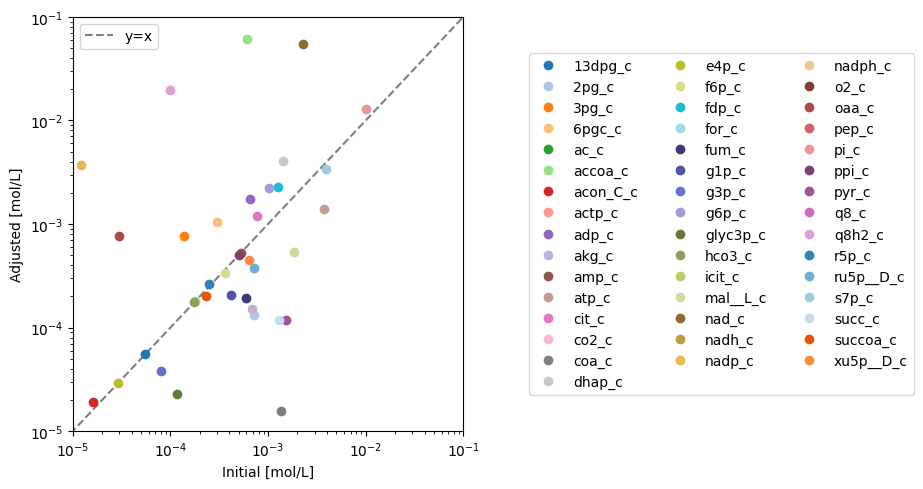

In [83]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_data["Concentration (mol * L-1)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_data.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [84]:
conc_data_for_comparison = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
conc_data_for_comparison.index.name = "ID"
conc_data_for_comparison.columns = ["Initial", "Adjusted"]
conc_data_for_comparison.to_csv("./data/analysis_data/concentrations_extended.csv")
conc_data_for_comparison

,Initial,Adjusted
ID,,
13dpg_c,0.000055,5.507545e-05
2pg_c,0.000725,1.312710e-04
3pg_c,0.000138,7.623383e-04
6pgc_c,0.000302,1.040886e-03
ac_c,0.000660,3.489012e+04
accoa_c,0.000606,6.123914e-02
acon_C_c,0.000016,1.893466e-05
actp_c,0.001070,4.984383e-01
adp_c,0.000656,1.755910e-03


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'Keq_CBLAT', 'Keq_RMPA', 'Keq_GLYt2pp', 'Keq_ARBtex', 'Keq_MPTAT', 'Keq_GUR1PPpp', 'Keq_ACACT5r', 'Keq_EX_rfamp_e', 'Keq_3OAR60', 'Keq_FACOAE140', 'Keq_EX_3hpp_e', 'Keq_OPMEACPR', 'Keq_GUI2', 'Keq_EX_fe3_e', 'Keq_RNDR4b', 'Keq_EX_orot_e', 'Keq_EX_cys__L_e', 'Keq_OPMEACPS', 'Keq_ETOHtex', 'Keq_HACD6', 'Keq_Zn2tex', 'Keq_DAGK160', 'Keq_EX_gsn_e', 'Keq_GLUN', 'Keq_EX_chol_e', 'Keq_INSt2pp', 'Keq_EX_f6p_e', 'Keq_PROt4pp', 'Keq_DDGLCNtex', 'Keq_MLTGY1pp', 'Keq_CLPNH180pp', 'Keq_SUCCt2_3pp', 'Keq_FRULYSK', 'Keq_Kt2pp', 'Keq_AMPtex', 'Keq_EX_tmao_e', 'Keq_EX_co2_e', 'Keq_GTPHs', 'Keq_ACGK', 'Keq_PUNP2', 'Keq_ADEtex', 'Keq_CRNCDH', 'Keq_UAMAGS', 'Keq_ARMEPNS', 'Keq_DHAPT', 'Keq_EX_ag_e', 'Keq_XMPtex', 'Keq_PAPA181', 'Keq_G3PAT120', 'Keq_NTPP1', 'Keq_PGPP140', 'Keq_HPPPNtex', 'Keq_GLYCtpp', 'Keq_MLTG1', 'Keq_GLYCAt2rpp', 'Keq_ANHGMtex', 'Keq_HMBS', 'Keq_R15BPK', 'Keq_FRD2', 'Keq_EX_gal1p_e', 'Keq_RZ5PP', 'Keq_RNTR1c2', 'Keq_CR

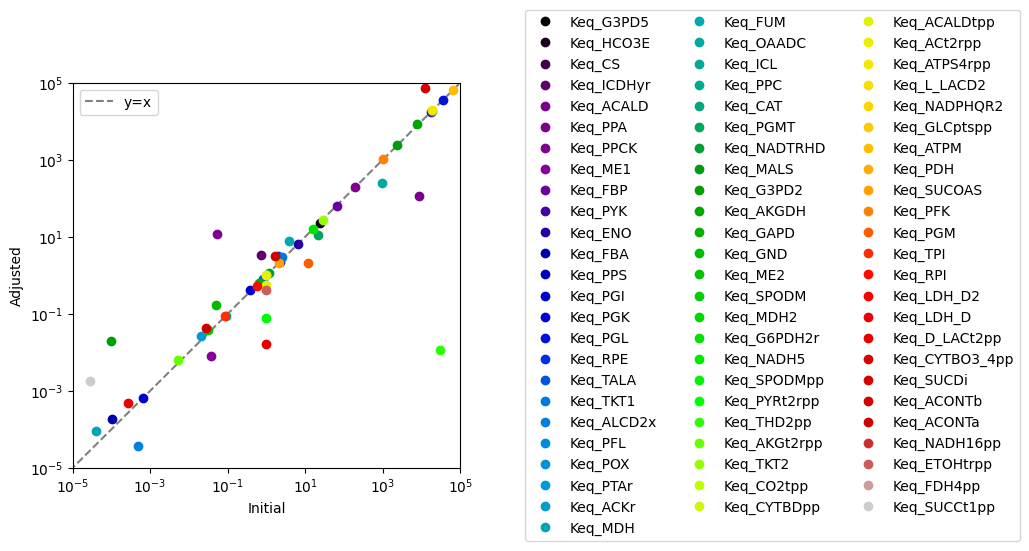

In [85]:
Keq_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_comparison(
    x=Keq_data["Equilibrium Constant"], y=conc_solution,
    compare="Keqs", ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [86]:
Keq_data_for_comparison = pd.concat(objs=(Keq_data, conc_solution.Keqs), axis=1).dropna()
Keq_data_for_comparison.index.name = "ID"
Keq_data_for_comparison.columns = ["Initial", "Adjusted"]
Keq_data_for_comparison.to_csv("./data/analysis_data/equilibrium_constants_extended.csv")
Keq_data_for_comparison

,Initial,Adjusted
ID,,
Keq_G3PD5,3.097852e+09,3.001950e+06
Keq_HCO3E,2.352797e+01,2.352797e+01
Keq_CS,4.465331e+06,4.465331e+06
Keq_ICDHyr,7.288431e-01,3.285634e+00
Keq_ACALD,8.884664e+03,1.129093e+02
...,...,...
Keq_ACONTa,2.777306e-02,4.330926e-02
Keq_NADH16pp,4.079883e+06,1.724759e+13
Keq_ETOHtrpp,1.000000e+00,4.279681e-01


In [87]:
# Fix Metabolite IDs as SBML compatible before next step
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [88]:
from pprint import pprint
pprint(vars(mass_model.metabolites.co2_c))

{'_annotation': {'bigg.metabolite': ['co2'],
                 'biocyc': ['META:CARBON-DIOXIDE'],
                 'chebi': ['CHEBI:23011',
                           'CHEBI:3283',
                           'CHEBI:48829',
                           'CHEBI:16526',
                           'CHEBI:13283',
                           'CHEBI:13285',
                           'CHEBI:13284',
                           'CHEBI:13282'],
                 'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/2ec3da94-5f50-4525-81b1-5607c5c7a3d3',
                              '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/05f60af4-0a3f-4ead-9a29-33bb0f123379'],
                 'hmdb': ['HMDB01967'],
                 'inchi_key': ['CURLTUGMZLYLDI-UHFFFAOYSA-N'],
                 'kegg.compound': ['C00011'],
                 'kegg.drug': ['D00004'],
                 'metanetx.chemical': ['MNXM13'],
                 'reactome.compound': ['29376',
                                       '56685

In [89]:
# #Set the metabolite for CO2 as a fixed metabolite using the "fixed" attribute (e.g., co2_c.fixed = True, etc.)
# mass_model.metabolites.co2_c.fixed = True
# mass_model.metabolites.co2_c.initial_condition = 0.001

In [90]:
n_models = 1

In [91]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

,g6p_c,glc__D_p,pep_c,pyr_c,f6p_c,adp_c,atp_c,fdp_c,pi_c,dhap_c,...,co2_p,ppi_c,h2o2_c,o2_c,o2s_c,h2o2_p,o2_p,o2s_p,for_p,lac__L_c
0,0.017583,0.008899,0.000013,0.000465,0.001944,0.004531,0.007677,0.014507,0.081291,0.005976,...,0.000182,0.000253,1.232707e-10,0.23341,0.000114,0.001399,0.001444,6.471971e-07,0.000106,0.000002


In [92]:
mass_model.fixed

{<MassMetabolite h_c at 0x1f8e8223f88>: 1,
 <MassMetabolite h2o_c at 0x1f8e8223bc8>: 1}

In [93]:
for x in mass_model.reactions:
    if x.steady_state_flux == 0:
        print(x.id)

LDH_D
D_LACt2pp
PYRt2rpp
ACALDtpp
ALCD2x
ETOHtrpp
OAADC
ME1
ME2
SUCCt1pp
AKGt2rpp
PGMT
G3PD2
CAT
SPODMpp
THD2pp
NADPHQR2
NADH5
LDH_D2
POX
G3PD5
L_LACD2
CYTBDpp


In [94]:
mass_model.metabolites.co2_c

MassMetabolite identifier,co2_c
Name,CO2 CO2
Memory address,0x01f8e8279888
Formula,CO2
Compartment,c
Initial Condition,1576.9617169472906
In 12 reaction(s),"ICDHyr, OAADC, GND, ME2, POX, PDH, ME1, AKGDH, HCO3E, PPCK, PPC, CO2tpp"


In [95]:
mass_model.reactions.ICDHyr

Reaction identifier,ICDHyr
Name,Isocitrate dehydrogenase (NADP)
Memory address,0x01f8e9203e08
Subsystem,Citric Acid Cycle
Kinetic Reversibility,True
Stoichiometry,icit_c + nadp_c <=> akg_c + co2_c + nadph_c Isocitrate + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + CO2 CO2 + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,b1136
Bounds,"(-1000.0, 1000.0)"


In [96]:
mass_model.reactions[0]

Reaction identifier,GLCptspp
Name,D-glucose transport via PEP:Pyr PTS (periplasm)
Memory address,0x01f8e8220248
Subsystem,"Transport, Inner Membrane"
Kinetic Reversibility,True
Stoichiometry,glc__D_p + pep_c <=> g6p_c + pyr_c D-Glucose + Phosphoenolpyruvate <=> D-Glucose 6-phosphate + Pyruvate
GPR,(b1621 and b2415 and b2417 and b2416) or (b1101 and b2416 and b2415 and b2417) or (b1819 and b2415 and b1818 and b1817 and b2416)
Bounds,"(0.0, 1000.0)"


### Balance network with pseudoreactions and calculate PERCs

In [97]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Creating model CentralMetabolism_C0
Number of models in ensemble: 1


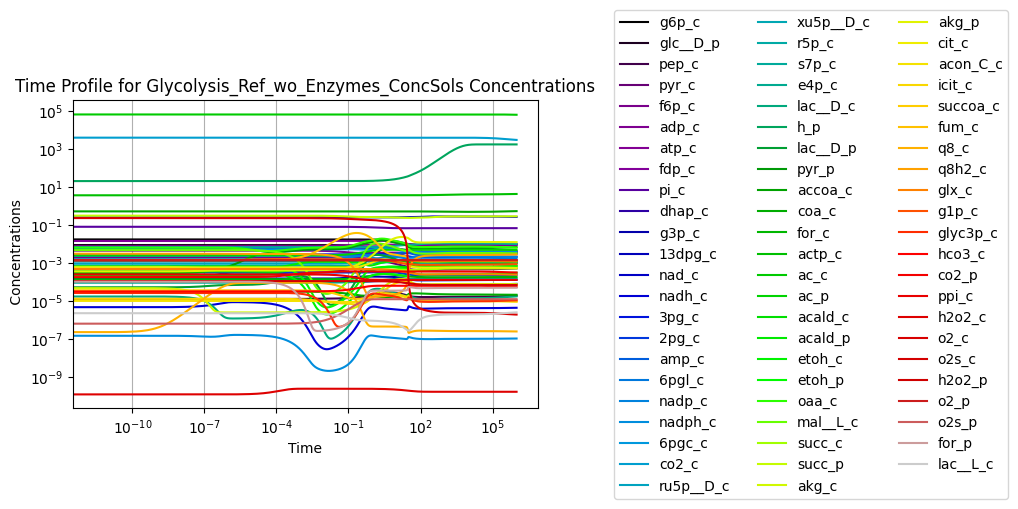

In [98]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

In [102]:
df = flux_sol_orig.to_frame()
df

,GLCptspp,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,...,SK_q8_c,SK_q8h2_c,SK_glx_c,SK_hco3_c,SK_co2_p,SK_ppi_c,SK_h2o2_c,SK_o2_c,SK_o2s_c,SK_for_p
Time,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.494698e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,1.328719e-07,9.845200e-12,6.731993e-19,6.723015e-16,1.184592e-12,4.993303e-15,1.102797e-14,6.696806e-12,4.771907e-20,7.111373e-15
4.989396e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,2.657433e-07,1.969036e-11,1.346399e-18,1.344603e-15,2.369298e-12,9.986607e-15,2.205594e-14,1.339359e-11,9.543813e-20,1.423427e-14
7.484093e-12,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,3.986142e-07,2.953548e-11,2.019598e-18,2.016905e-15,3.554117e-12,1.497991e-14,3.308391e-14,2.009034e-11,1.431572e-19,2.136869e-14
1.527795e-11,0.004196,0.002485,0.003389,0.000308,0.003081,0.003066,0.006858,-0.006858,-0.006354,0.006354,...,8.137217e-07,6.029304e-11,4.125568e-18,4.117272e-15,7.256431e-12,3.058004e-14,6.753715e-14,4.101196e-11,2.921038e-19,4.373287e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.216051e+05,0.002515,0.001323,0.002306,0.000200,0.002106,0.002111,0.004687,-0.004687,-0.004809,0.004809,...,7.805506e-06,7.805542e-06,5.757784e-06,7.092579e-05,6.966551e-03,3.455081e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868997e-04
9.471058e+05,0.002515,0.001323,0.002307,0.000200,0.002107,0.002111,0.004688,-0.004688,-0.004810,0.004810,...,7.781904e-06,7.781938e-06,5.759472e-06,7.080676e-05,6.955304e-03,3.455123e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868636e-04
9.726065e+05,0.002516,0.001324,0.002307,0.000200,0.002107,0.002112,0.004689,-0.004689,-0.004811,0.004811,...,7.759994e-06,7.760025e-06,5.761042e-06,7.069615e-05,6.944854e-03,3.455162e-04,2.819638e-07,8.334631e-03,5.639277e-07,2.868302e-04


In [103]:
df['SK_glc__D_p']

Time
0.000000e+00    0.000000e+00
2.494698e-12    4.936393e-15
4.989396e-12    9.872786e-15
7.484093e-12    1.480918e-14
1.527795e-11    3.023019e-14
                    ...     
9.216051e+05    2.514671e-03
9.471058e+05    2.515446e-03
9.726065e+05    2.516165e-03
9.981071e+05    2.516834e-03
1.000000e+06    2.516880e-03
Name: SK_glc__D_p, Length: 3481, dtype: float64

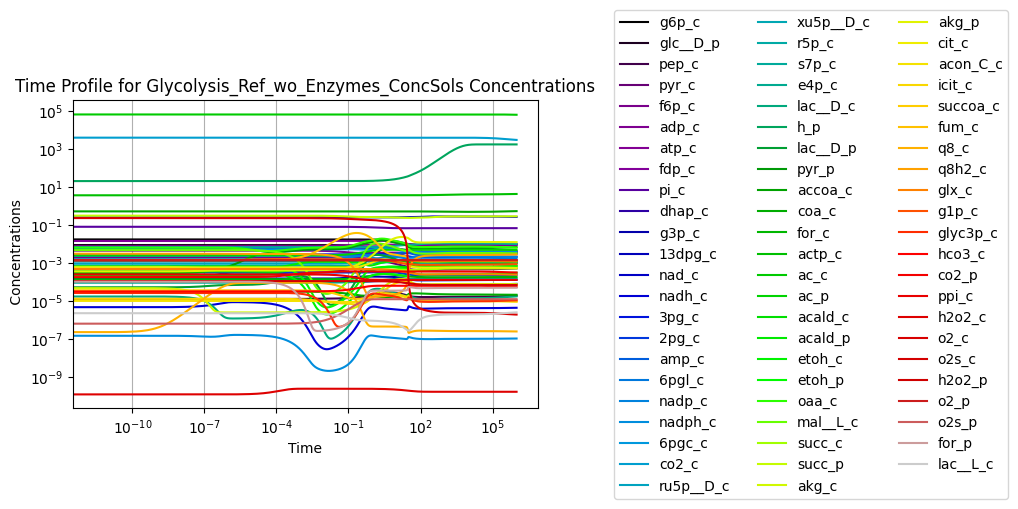

In [106]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

In [121]:
mass_model

Name,CentralMetabolism
Memory address,0x01a2bbc416c8
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,70/70
Number of reactions,73
Number of genes,67
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [123]:
mass_model.metabolites

There are no boundary reactions in this model. Therefore, specific types of boundary reactions such as 'exchanges', 'demands' or 'sinks' cannot be identified.


[]

In [130]:
conc_sol_orig.pyr_p

array([0.00029965, 0.00029965, 0.00029965, ..., 0.00690055, 0.00690499,
       0.00690529])

In [134]:
mass_model.reactions.PGI.Keq

0.4056431534279425

In [140]:
mass_model.rates

{<MassReaction GLCptspp at 0x1a2bbc41108>: kf_GLCptspp*(glc__D_p(t)*pep_c(t) - g6p_c(t)*pyr_c(t)/Keq_GLCptspp),
 <MassReaction PGI at 0x1a2bbc41648>: kf_PGI*(g6p_c(t) - f6p_c(t)/Keq_PGI),
 <MassReaction PFK at 0x1a2bbc3cf08>: kf_PFK*(atp_c(t)*f6p_c(t) - adp_c(t)*fdp_c(t)/Keq_PFK),
 <MassReaction FBP at 0x1a2bbc3cd88>: kf_FBP*(fdp_c(t) - f6p_c(t)*pi_c(t)/Keq_FBP),
 <MassReaction FBA at 0x1a2bbc3c4c8>: kf_FBA*(fdp_c(t) - dhap_c(t)*g3p_c(t)/Keq_FBA),
 <MassReaction TPI at 0x1a2bbc3c288>: kf_TPI*(dhap_c(t) - g3p_c(t)/Keq_TPI),
 <MassReaction GAPD at 0x1a2bbc3c3c8>: kf_GAPD*(g3p_c(t)*nad_c(t)*pi_c(t) - _13dpg_c(t)*nadh_c(t)/Keq_GAPD),
 <MassReaction PGK at 0x1a2bbc38cc8>: kf_PGK*(_3pg_c(t)*atp_c(t) - _13dpg_c(t)*adp_c(t)/Keq_PGK),
 <MassReaction PGM at 0x1a2bbc382c8>: kf_PGM*(_2pg_c(t) - _3pg_c(t)/Keq_PGM),
 <MassReaction ENO at 0x1a2bbc3cd08>: kf_ENO*(_2pg_c(t) - pep_c(t)/Keq_ENO),
 <MassReaction PYK at 0x1a2b5bbde48>: kf_PYK*(adp_c(t)*pep_c(t) - atp_c(t)*pyr_c(t)/Keq_PYK),
 <MassReaction 

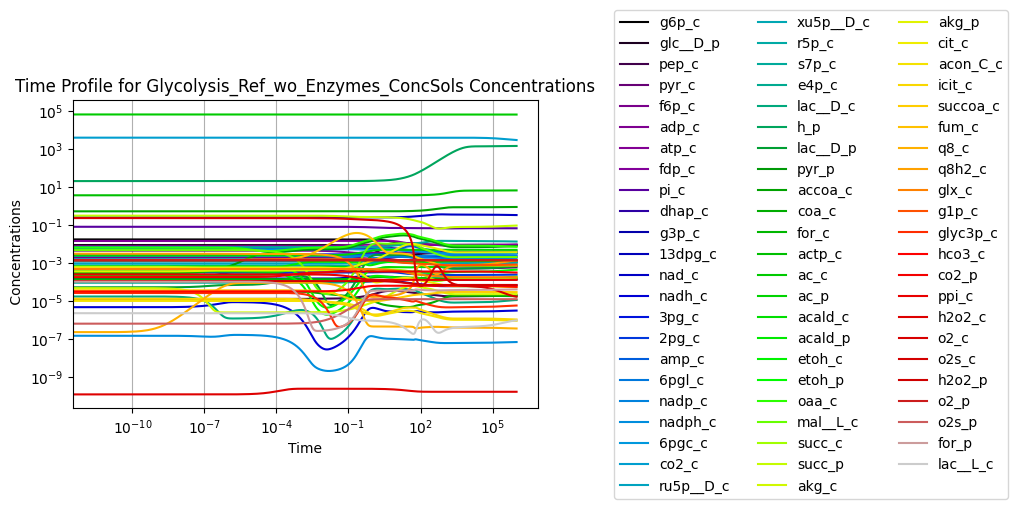

In [107]:
conc_sol_pert, flux_sol_pert = sim.simulate(
    reference_model, time=(0, tfinal), perturbations={"kf_CS": "kf_CS * 0.05"})
conc_sol_pert.view_time_profile()

In [108]:
#Citrate should deplete
print("Citrate WT is: " + str(conc_sol_orig.cit_c[-1]))
print("Citrate with CS inhibited is: " + str(conc_sol_pert.cit_c[-1]))

#succoa should deplete
print("Succoa WT is: " + str(conc_sol_orig.succoa_c[-1]))
print("Succoa with CS inhibited is: " + str(conc_sol_pert.succoa_c[-1]))

#Malate should accumulate
print("Malate WT is: " + str(conc_sol_orig.mal__L_c[-1]))
print("Malate with CS inhibited is: " + str(conc_sol_pert.mal__L_c[-1]))

#accoa should accumulate
print("Accoa original is: " + str(conc_sol_orig.accoa_c[-1]))
print("Accoa original is: " + str(conc_sol_pert.accoa_c[-1]))

Citrate WT is: 0.0005543253778296531
Citrate with CS inhibited is: 5.3458061557317365e-05
Succoa WT is: 7.000522936910814e-05
Succoa with CS inhibited is: 2.9677421968573877e-05
Malate WT is: 0.0032634638490424174
Malate with CS inhibited is: 0.002072576592630009
Accoa original is: 0.5384441481737864
Accoa original is: 0.8910946092104374


#### Save a reference MASS model w/o enzymes

In [109]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", 
    tfinal=tfinal)
if conc_sol and flux_sol:
    reference_model.update_initial_conditions(conc_sol)
    reference_model.update_parameters({f"v_{k}": v for k, v in flux_sol.items()})
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/without_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

mass\simulation\simulation.py:902 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.
ERROR: Unable to find a steady state for 'Glycolysis_Ref_wo_Enzymes' using strategy 'simulate' due to the following: For MassModel "Glycolysis_Ref_wo_Enzymes", absolute difference for "['[co2_c]', '[h_p]', '[actp_c]', '[ac_c]']" is greater than the steady state threshold.


Name,Glycolysis_Ref_wo_Enzymes
Memory address,0x01a2b9a9a908
Stoichiometric Matrix,70x123
Matrix Rank,68
Number of metabolites,70
Initial conditions defined,70/70
Number of reactions,123
Number of genes,67
Number of enzyme modules,0
Number of groups,0
Objective expression,0


## Create Enzyme Modules

Assume 90% of flux goes through the major isozyme, the remaining through the minor isozyme

In [28]:
from construction_functions import make_enzyme_module_from_dir

In [29]:
isozyme1_percent = 0.9
isozyme2_percent = 0.1

# Isozymes and flux split percentages,
isozymes_and_flux_splits = {
    "PFK": {
        "PFK1": isozyme1_percent,
        "PFK2": isozyme2_percent,
    },
    "FBP": {
        "FBP1": isozyme1_percent,
        "FBP2": isozyme2_percent,
    },
    "FBA": {
        "FBA1": isozyme1_percent,
        "FBA2": isozyme2_percent,
    },
    "PGM": {
        "PGMi": isozyme1_percent,
        "PGMd": isozyme2_percent,
    },
    "PYK": {
        "PYK1": isozyme1_percent,
        "PYK2": isozyme2_percent,
    },
}
        
isozymes_and_flux_splits

{'PFK': {'PFK1': 0.9, 'PFK2': 0.1},
 'FBP': {'FBP1': 0.9, 'FBP2': 0.1},
 'FBA': {'FBA1': 0.9, 'FBA2': 0.1},
 'PGM': {'PGMi': 0.9, 'PGMd': 0.1},
 'PYK': {'PYK1': 0.9, 'PYK2': 0.1}}

In [30]:
final_ensemble = []
for model in models_for_ensemble:
    enzyme_modules = {}
    for reaction in model.reactions.get_by_any(reaction_list):
        # PGM & PGK needs flux flipped since enzyme module stoichiometry
        # is reversed compared to lone reaction.
        if reaction.id in ["PGK", "PGM"]:
            flux = -reaction.steady_state_flux
        else:
            flux = reaction.steady_state_flux
        # Make isozymes
        if reaction.id in isozymes_and_flux_splits:
            isozymes_and_flux_split = isozymes_and_flux_splits[reaction.id]
            isozyme_modules = []
            for isozyme, flux_split in isozymes_and_flux_split.items():
                enzyme_module = make_enzyme_module_from_dir(
                    enzyme_id=isozyme,
                    steady_state_flux=flux * flux_split, # Split flux for isozymes
                    metabolite_concentrations=model.initial_conditions,
                    path_to_dir="./data/enzyme_module_data",
                    kcluster=1,
                    enzyme_gpr=reaction.gene_reaction_rule,
                    zero_tol=1e-10)
                isozyme_modules += [enzyme_module]
            enzyme_modules[reaction] = isozyme_modules
        else:
            enzyme_module = make_enzyme_module_from_dir(
                enzyme_id=reaction.id,
                steady_state_flux=flux,
                metabolite_concentrations=new_model.initial_conditions,
                path_to_dir="./data/enzyme_module_data",
                kcluster=1,
                enzyme_gpr=reaction.gene_reaction_rule,
                zero_tol=1e-10)
            enzyme_modules[reaction] = [enzyme_module]
    for reaction_to_remove, enzymes_to_add in enzyme_modules.items():
        model.remove_reactions([reaction_to_remove])
        for enzyme in enzymes_to_add:
            model = model.merge(enzyme, inplace=True)
    final_ensemble += [model]
    print(f"Finished {model.id}")

Finished Glycolysis_C0
Finished Glycolysis_C1
Finished Glycolysis_C2
Finished Glycolysis_C3
Finished Glycolysis_C4


# Inspect a model

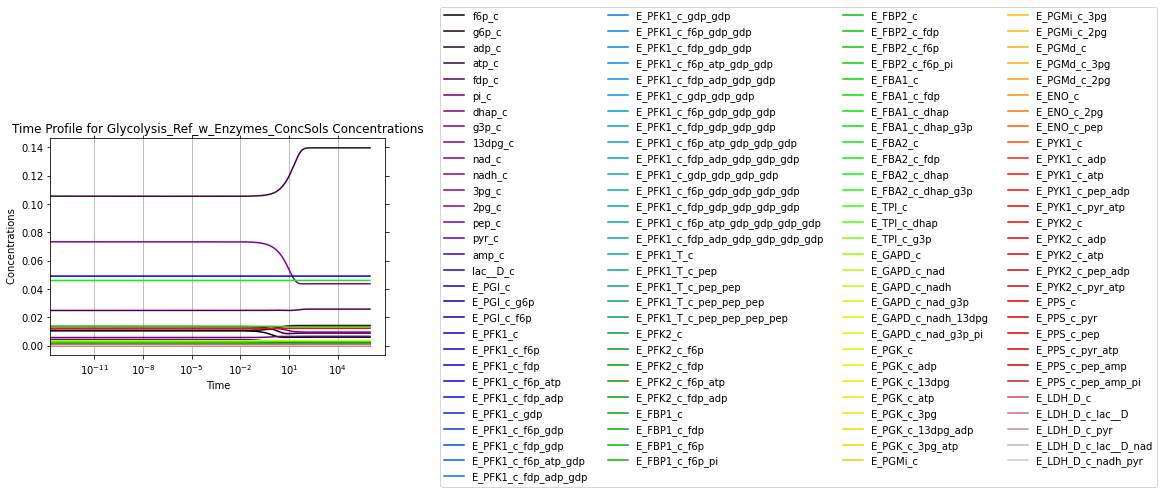

In [31]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_w_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol, flux_sol = sim.simulate(reference_model, time=(0, tfinal))
conc_sol.view_time_profile(plot_function="semilogx")


#### Save a reference MASS model w/ enzymes

In [32]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", update_values=True,
    tfinal=tfinal)
if conc_sol and flux_sol:
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/with_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

Saving Glycolysis_Ref_w_Enzymes


Name,Glycolysis_Ref_w_Enzymes
Memory address,0x01b692ddde50
Stoichiometric Matrix,120x121
Matrix Rank,102
Number of metabolites,120
Initial conditions defined,120/120
Number of reactions,121
Number of genes,19
Number of enzyme modules,17
Number of groups,0
Objective expression,0


## Simulate to steady state and export ensemble

In [33]:
sim = Simulation(final_ensemble[0])
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9
sim.add_models(final_ensemble[1:], disable_safe_load=True)
for model in final_ensemble:
    # Attempt to determine steady state
    conc_sol, flux_sol = sim.find_steady_state(
        models=model, strategy="simulate", update_values=True,
        tfinal=tfinal)
    if conc_sol and flux_sol:
        # Save a reference MASS model
        save_mass_json_model(
            mass_model=model,
            filename=f"./models/mass/with_enzymes/{model.id}.json")
        print(f"Saving {model.id}")
    else:
        print(f"No steady state for {model.id}.")

Saving Glycolysis_C0
Saving Glycolysis_C1
Saving Glycolysis_C2
Saving Glycolysis_C3
Saving Glycolysis_C4
